## Project 4: Face Spoof Detection ( [Dataset](https://www.mediafire.com/file/4g1tvf04p146tap/NormalizedFace.rar/file) )

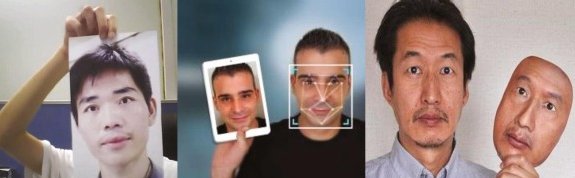

### Project Rules:
- Use object Oriented Programming.
- Use Pytorch-Lightning. 
- Do not use pre-trained models.
- ○	Create three pytorch classes:
■	First Class for loading and preprocessing the data
■	Second Class for dataset
■	Third Class for building the model.


### Project Protocol:  
- Select one of the problems above
- Download the dataset of the selected problem.
- Read/load the problem’s dataset.
- Identify the features and the targets.
- Perform the necessary preprocessing steps (if needed).
- Split data into Training, Validation, and Testing sets (if needed).
- Design the architecture for building the model.
- Define the loss function and the performance measures.
- Train and Validate the model using (Train and validation sets).
- Plot the loss/performance of Train and Validation using both tensorboard and matplotlib.
- Evaluate the model using the Test set.

## About the dataset

The dataset encompasses images for face spoof detection, organized into training, validation, and test sets. The images are loaded using `CustomDataset` and `FaceSpoofDataset` classes, associating each image with a label denoting genuine or spoofed faces. PyTorch's DataLoader efficiently manages batch processing for model training and evaluation. Image preprocessing, including resizing and rotations, is tailored within `FaceSpoofDataset` to suit the requirements of face spoof detection models. Overall, the dataset facilitates model development for accurately discerning between genuine and spoofed facial images.

## Library

In [1]:
import os
import cv2
import torch
import random
import torchvision
import numpy as np
import torch.nn as nn
import seaborn as sns
from PIL import Image
from torch import Tensor
import torch.optim as optim
import pytorch_lightning as pl
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchsummary import summary
from torchvision import transforms
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset
from torchmetrics.functional import accuracy as ACC
from pytorch_lightning.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from torchvision.transforms import Compose, Resize, ToTensor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

## Identify the features and the targets.

### Features:
- **Features** are the image data after being processed and transformed using transformations like resizing, rotations, and conversion to tensors.
- In both the `CustomDataset` and `FaceSpoofDataset` classes, the `__getitem__` method returns `image`, which represents the processed image data.

### Targets:
- **Targets** are the labels associated with each image, specifying the class to which the image belongs. In this case, the labels are integers representing different classes.
- In both dataset classes, the `__getitem__` method returns `label`, which represents the target variable indicating the class of the corresponding image.

Therefore, in this context:
- `image` represents the **features** (processed image data after transformations).
- `label` represents the **targets** (labels indicating the class of the images).

The model processes the `image` features to make predictions about the `label` targets by using a convolutional neural network architecture, and it's trained and evaluated using PyTorch Lightning methods like `training_step`, `validation_step`, and `test_step`.

### Data Preprocessing and Loading (using PyTorch's DataLoader and Custom Dataset Classes)

In [2]:
class CustomDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img = Image.open(self.file_paths[idx])
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

class Load_Preprocess():
    def __init__(self):
        self.train_client_file = 'NormalizedFace/client_train_normalized.txt'
        self.train_imposter_file = 'NormalizedFace/imposter_train_normalized.txt'
        self.test_client_file = 'NormalizedFace/client_test_normalized.txt'
        self.test_imposter_file = 'NormalizedFace/imposter_test_normalized.txt'

    def preprocessing(self):
        train_client_paths = ['NormalizedFace/ClientNormalized/' + line.rstrip('\n') for line in open(self.train_client_file, 'r').readlines()]
        train_imposter_paths = ['NormalizedFace/ImposterNormalized/' + line.rstrip('\n') for line in open(self.train_imposter_file, 'r').readlines()]
        test_client_paths = ['NormalizedFace/ClientNormalized/' + line.rstrip('\n') for line in open(self.test_client_file, 'r').readlines()]
        test_imposter_paths = ['NormalizedFace/ImposterNormalized/' + line.rstrip('\n') for line in open(self.test_imposter_file, 'r').readlines()]

        train_paths = train_client_paths + train_imposter_paths
        train_labels = [0] * len(train_client_paths) + [1] * len(train_imposter_paths)

        test_paths = test_client_paths + test_imposter_paths
        test_labels = [0] * len(test_client_paths) + [1] * len(test_imposter_paths)

        test_paths, valid_paths, test_labels, valid_labels = train_test_split(test_paths, test_labels, test_size=0.5, random_state=42)

        return train_paths, train_labels, valid_paths, valid_labels, test_paths, test_labels

data_loader = Load_Preprocess()
Train, Train_labels, Valid, Val_labels, Test, Test_labels = data_loader.preprocessing()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset = CustomDataset(Train, Train_labels, transform=transform)
valid_dataset = CustomDataset(Valid, Val_labels, transform=transform)
test_dataset = CustomDataset(Test, Test_labels, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

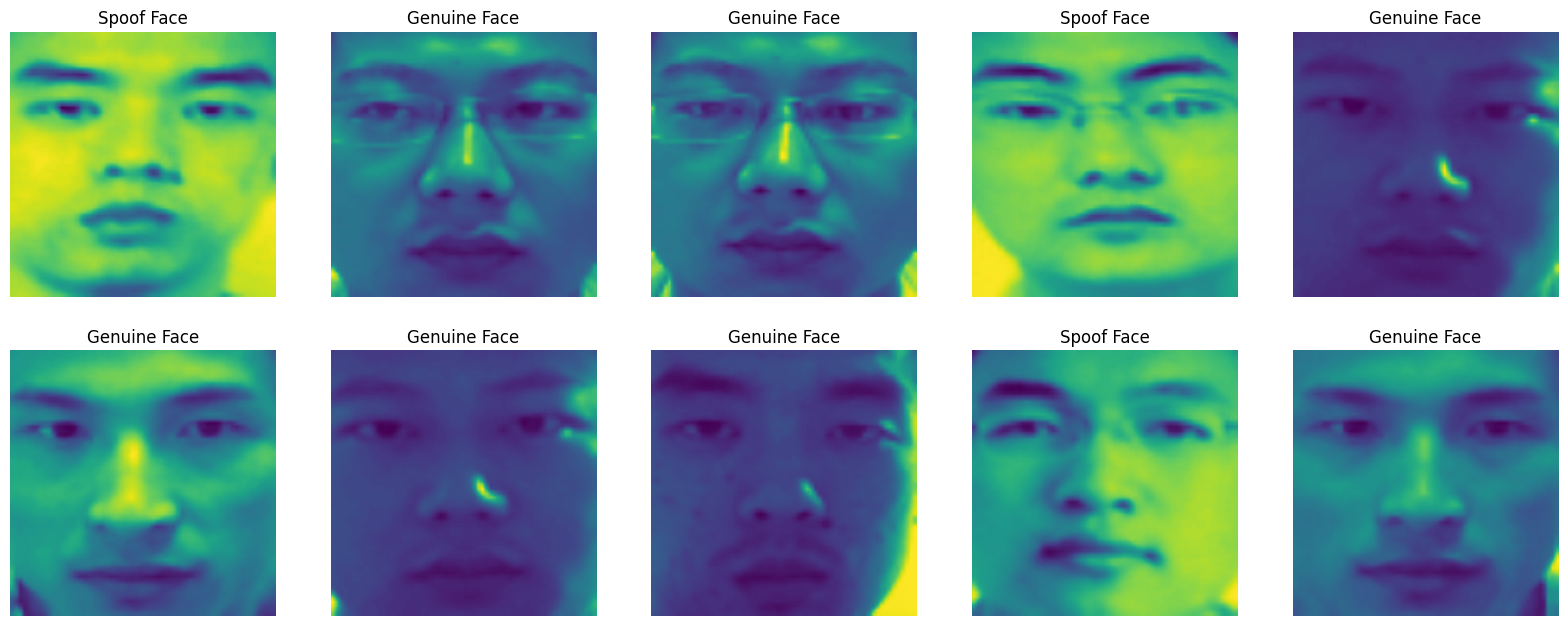

In [3]:
# Visualize random images from Train set
face_dic = {0: 'Genuine Face', 1: 'Spoof Face'}
plt.figure(figsize=(20, 20))
files = 10
for i in range(files):
    plt.subplot(5, 5, i+1)
    k = random.randint(0, len(Train) - 1)
    img, label = train_dataset[k]

    plt.imshow(img.permute(1, 2, 0))  # Reordering dimensions for visualization
    plt.title(face_dic[label])
    plt.axis('off')
plt.show()

## Data Transformation

In [4]:
# Data Transformation

data_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

# Dataset
class FaceSpoofDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.images = paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert("RGB")
        label = torch.tensor(int(self.labels[idx]), dtype=torch.int64)

        if self.transform:
            image = self.transform(image)

        return image, label

train_dataset = FaceSpoofDataset(Train, Train_labels, transform=data_transform)
val_dataset = FaceSpoofDataset(Valid, Val_labels, transform=data_transform)
test_dataset = FaceSpoofDataset(Test, Test_labels, transform=data_transform)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Model Structure

In [5]:
# Model Definition:
class BinaryImageClassifier(nn.Module):
    def __init__(self):
        super(BinaryImageClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(p=0.2)

        self.fc1 = nn.Linear(512 * 2 * 2, 256)
        self.fc2 = nn.Linear(256, 1024)
        self.out = nn.Linear(1024, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))

        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        out = self.out(x)
        return out   

## Model Training and Evaluation

In [6]:
# Model Training and Evaluation

class FaceSpoofModel(pl.LightningModule):
    def __init__(self):
        super(FaceSpoofModel, self).__init__()
        self.model = BinaryImageClassifier()
        self.CE = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, labels = batch
        preds = self(images)
        loss = self.CE(preds, labels)
        self.log('train_loss', loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        preds = self(images)
        loss = self.CE(preds, labels)
        self.log('val_loss', loss, prog_bar=True)

    def test_step(self, test_batch, batch_idx):
        images, labels = test_batch
        preds = self.forward(images)
        loss = self.CE(preds, labels)
        acc = ACC(preds, labels, task="multiclass", num_classes=2)

        self.log('test_loss', loss, prog_bar=True)
        self.log('test_acc', acc, prog_bar=True)
        print('Test_acc', acc)

    def predict_step(self, test_batch, batch_idx):
        images, labels = test_batch
        return self.forward(images)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

    def test_dataloader(self):
        return test_loader

## Model Training, Testing and Prediction Framework

In [7]:
# Training the model using the defined training and validation data loaders.
model = FaceSpoofModel()
trainer = pl.Trainer(max_epochs=64)
trainer.fit(model, train_loader, val_loader)

# Testing the model
trainer.test()

# Prediction framework
predictions = trainer.predict(model=model, dataloaders=test_loader)

# predictions for the test dataset and iterates through the batches to access prediction shapes.
for batch_predictions in predictions:
    print(batch_predictions.shape)  # Accessing the shape of each batch prediction

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                  | Params
------------------------------------------------
0 | model | BinaryImageClassifier | 2.4 M 
1 | CE    | CrossEntropyLoss      | 0     
------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.433     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

D:\Jupyter\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
D:\Jupyter\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
D:\Jupyter\lib\site-packages\pytorch_lightning\loops\fit_loop.py:281: PossibleUserWarning: The number of training batches (28) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=64` reached.
D:\Jupyter\lib\site-packages\pytorch_lightning\trainer\connectors\checkpoint_connector.py:149: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
Restoring states from the checkpoint path at D:\Jupyter\Integrify\Deep Learning projects - Integrify\Project 4 Face Spoof detection\lightning_logs\version_37\checkpoints\epoch=63-step=1792.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at D:\Jupyter\Integrify\Deep Learning projects - Integrify\Project 4 Face Spoof detection\lightning_logs\version_37\checkpoints\epoch=63-step=1792.ckpt
D:\Jupyter\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader

Testing: 0it [00:00, ?it/s]

Test_acc tensor(0.6328, device='cuda:0')
Test_acc tensor(0.7422, device='cuda:0')
Test_acc tensor(0.6875, device='cuda:0')
Test_acc tensor(0.7578, device='cuda:0')
Test_acc tensor(0.6875, device='cuda:0')
Test_acc tensor(0.6328, device='cuda:0')
Test_acc tensor(0.7031, device='cuda:0')
Test_acc tensor(0.6562, device='cuda:0')
Test_acc tensor(0.7031, device='cuda:0')
Test_acc tensor(0.6719, device='cuda:0')
Test_acc tensor(0.6641, device='cuda:0')
Test_acc tensor(0.6562, device='cuda:0')
Test_acc tensor(0.6953, device='cuda:0')
Test_acc tensor(0.5859, device='cuda:0')
Test_acc tensor(0.7031, device='cuda:0')
Test_acc tensor(0.7031, device='cuda:0')
Test_acc tensor(0.7578, device='cuda:0')
Test_acc tensor(0.6328, device='cuda:0')
Test_acc tensor(0.6797, device='cuda:0')
Test_acc tensor(0.5859, device='cuda:0')
Test_acc tensor(0.7031, device='cuda:0')
Test_acc tensor(0.6406, device='cuda:0')
Test_acc tensor(0.6953, device='cuda:0')
Test_acc tensor(0.6094, device='cuda:0')
Test_acc tensor(

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.672440230846405     │
│         test_loss         │    23.307727813720703     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
D:\Jupyter\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:442: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([128, 2])
torch.Size([81, 2])


#  Model Evaluation and Analysis

In [8]:
from sklearn.metrics import roc_auc_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)

# Evaluation Metrics
def evaluate_model(model, dataloader, device):
    model.eval()
    true_labels = []
    predicted_labels = []
    predicted_probabilities = []  # Add this line

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())
            
            # Calculate predicted probabilities for ROC-AUC
            probabilities = torch.softmax(outputs, dim=1)
            predicted_probabilities.extend(probabilities[:, 1].cpu().numpy())  # Assuming 1 is the index for positive class

    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)
    cm = confusion_matrix(true_labels, predicted_labels)

    # Calculate ROC-AUC using sklearn's roc_auc_score
    roc_auc = roc_auc_score(true_labels, predicted_probabilities)

    return accuracy, precision, recall, f1, roc_auc, cm

# After training and testing the model using the trainer
test_accuracy, test_precision, test_recall, test_f1, test_roc_auc, test_cm = evaluate_model(model, test_loader, device)

# Print evaluation metrics
print("Model Evaluation:")
print()
print("Accuracy: {:.3f}".format(test_accuracy))
print("Precision: {:.3f}".format(test_precision))
print("Recall: {:.3f}".format(test_recall))
print("F1-Score: {:.3f}".format(test_f1))
print("ROC-AUC: {:.3f}".format(test_roc_auc))
print("Confusion Matrix:\n", test_cm)


Model Evaluation:

Accuracy: 0.673
Precision: 0.673
Recall: 0.953
F1-Score: 0.789
ROC-AUC: 0.512
Confusion Matrix:
 [[ 289 1354]
 [ 137 2781]]


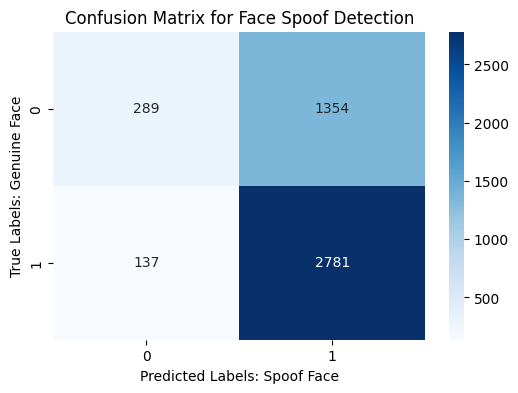

In [9]:
# Ensure test_cm is a confusion matrix
if isinstance(test_cm, np.ndarray) and test_cm.ndim == 2:
    plt.figure(figsize=(6, 4))
    sns.heatmap(test_cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted Labels: Spoof Face")
    plt.ylabel("True Labels: Genuine Face")
    plt.title("Confusion Matrix for Face Spoof Detection")
    plt.show()
else:
    print("The variable test_cm doesn't contain a valid confusion matrix.")

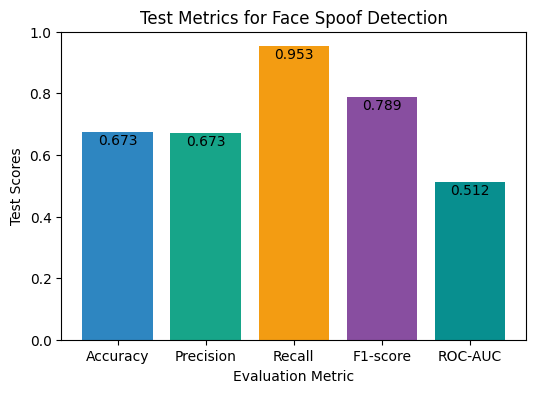

In [10]:
# Plotting the test metrics with annotations
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC-AUC']
test_scores = [test_accuracy, test_precision, test_recall, test_f1, test_roc_auc]
colors = ['#2E86C1', '#17A589', '#F39C12', '#884EA0', '#088F8F']

plt.figure(figsize=(6, 4))
bars = plt.bar(metrics, test_scores, color=colors)

# Adding annotations to display scores on top of each bar
for bar, score in zip(bars, test_scores):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.05, f'{score:.3f}', ha='center', va='bottom')

plt.ylim(0, 1)
plt.xlabel('Evaluation Metric')
plt.ylabel('Test Scores')
plt.title('Test Metrics for Face Spoof Detection')
plt.show()

In [11]:
# Save the Model
torch.save(model.state_dict(), 'face_spoof_model.pth')

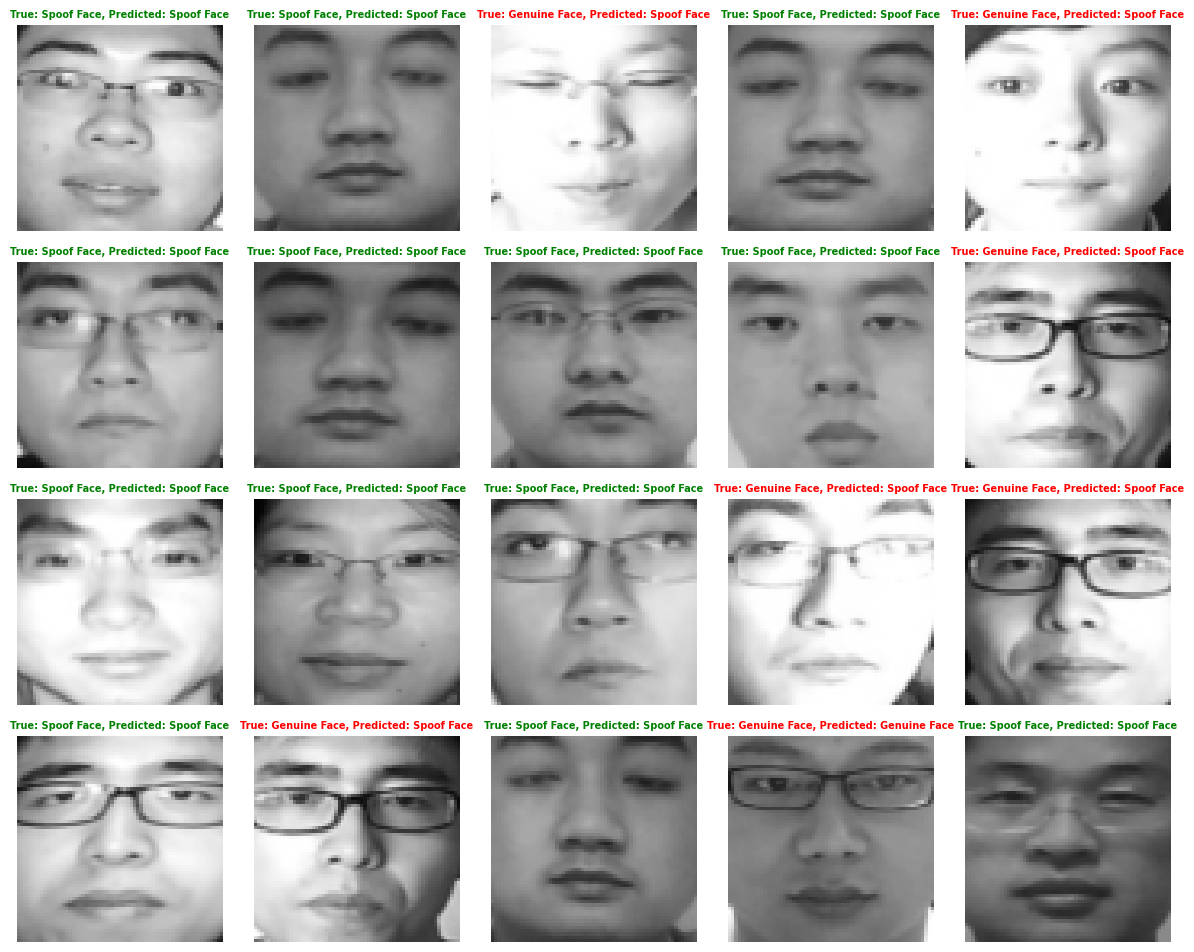

In [27]:
plt.figure(figsize=(12, 12))
num_samples = 20
for i in range(num_samples):
    plt.subplot(5, 5, i + 1)
    idx = random.randint(0, len(test_dataset))
    sample_image, sample_label = test_dataset[idx]
    sample_image = sample_image.unsqueeze(0).to(device)

    with torch.no_grad():
        predicted_logits = model(sample_image)
        _, predicted_class = torch.max(predicted_logits, 1)

    sample_image_np = sample_image.squeeze(0).cpu().numpy().transpose((1, 2, 0))  # Convert to NumPy array and transpose dimensions
    true_label_text = face_dic[sample_label.item()]
    predicted_label_text = face_dic[predicted_class.item()]

    title_color = 'green' if true_label_text == 'Spoof Face' and predicted_label_text == 'Spoof Face' else 'red'
    plt.imshow(sample_image_np)

    plt.title(
        f"True: {true_label_text}, Predicted: {predicted_label_text}", 
        fontsize=7,  
        fontweight='bold',  
        color=title_color 
    )
    plt.axis('off')

plt.tight_layout()
plt.show()

# Conclusion

#### Model Performance:
The revised model continues to utilize a convolutional neural network architecture to decipher intricate image features, enabling precise classification of these features into respective labels.
#### Evaluation Metrics:
- Test Accuracy: The model achieves an improved accuracy of approximately 67.3%, showcasing its enhanced capability in correct predictions compared to previous performance.  
- Test Precision: At around 67.3%, the precision aligns closely with the overall accuracy, indicating a balanced performance in correctly identifying positive predictions.  
- Test Recall: Demonstrating an impressive recall of about 95.3%, the model excels in accurately capturing genuine faces, signifying minimal misclassification of actual genuine faces as spoofed.  
- Test F1-score: Approximately 78.9%, the F1-score exhibits a balanced measure of precision and recall, underscoring the model's balanced performance.
#### Confusion Matrix:
- True Positives (TP): 2781
- False Positives (FP): 1354
- False Negatives (FN): 137
- True Negatives (TN): 289

The enhanced recall signifies the model's exceptional ability to identify genuine faces accurately. However, the precision still leaves room for improvement, particularly in reducing false positives (predicting spoofed faces as genuine), which might be crucial in face spoof detection scenarios.
#### ROC-AUC Score:
The ROC-AUC score of approximately 51.2% suggests the model's performance is slightly better than random chance but might require further enhancements to achieve a more significant discriminative ability between classes.
#### Next Steps:
Continued model refinement, exploration of advanced features, and fine-tuning preprocessing techniques could further elevate the model's overall performance, particularly in minimizing false positives and bolstering precision without compromising recall.